In [11]:
import json
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import yaml
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO
import shutil

In [5]:
import os
import shutil
import json
import yaml
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import requests

def make_dirs(dir="new_dir/"):
    """Creates a directory with subdirectories 'labels' and 'images', removing existing ones."""
    dir = Path(dir)
    if dir.exists():
        shutil.rmtree(dir)  # delete dir
    for p in dir, dir / "labels", dir / "images":
        p.mkdir(parents=True, exist_ok=True)  # make dir
    return dir

def convert(file, zip=True):
    """Converts Labelbox NDJSON labels to YOLO format and saves them, with optional zipping."""
    names = []  # class names
    file = Path(file)
    save_dir = make_dirs(f'/media/avalocal/T9/harsha/datasets/{file.stem}')
    with open(file) as f:
        lines = f.readlines()  # Read the file line by line

    data = [json.loads(line) for line in lines]  # Parse each line as JSON
    
    for img in tqdm(data, desc=f"Converting {file}"):
        # print(img)
        data = img['data_row']
        im_path = data['row_data']
        im = Image.open(requests.get(im_path, stream=True).raw if im_path.startswith("http") else im_path)  # open
        width, height = im.size  # image size
        label_path = save_dir / "labels" / Path(data["external_id"]).with_suffix(".txt").name
        image_path = save_dir / "images" / data["external_id"]
        im.save(image_path, quality=95, subsampling=0)

        # print(img['projects']['clwb1ya3l00w307z746dy5uh6']['labels'])

        # for label in img["Label"]["objects"]:
        for label in img['projects']['clwb1ya3l00w307z746dy5uh6']['labels']:
            # box
            # print(label)
            # top, left, h, w = label["bbox"].values()  # top, left, height, width
            for key in label['annotations']['objects']:
                top, left, h, w = key["bounding_box"].values()  # top, left, height, width
                xywh = [(left + w / 2) / width, (top + h / 2) / height, w / width, h / height]  # xywh normalized

                # class
                cls = key["value"]  # class name
                if cls not in names:
                    names.append(cls)

                line = names.index(cls), *xywh  # YOLO format (class_index, xywh)
                with open(label_path, "a") as f:
                    f.write(("%g " * len(line)).rstrip() % line + "\n")

    # Save dataset.yaml
    d = {
        "path": f"../datasets/{file.stem}",  # dataset root dir
        "train": "images/train",  # train images (relative to path) 128 images
        "val": "images/val",  # val images (relative to path) 128 images
        "test": "",  # test images (optional)
        "nc": len(names),
        "names": names,
    }  # dictionary

    with open(save_dir / file.with_suffix(".yaml").name, "w") as f:
        yaml.dump(d, f, sort_keys=False)

    # Zip
    if zip:
        print(f"Zipping as {save_dir}.zip...")
        shutil.make_archive(save_dir, 'zip', save_dir)

    print("Conversion completed successfully!")

if __name__ == "__main__":
    convert("/media/avalocal/T9/harsha/Labelbox_data_final.ndjson")


Converting /media/avalocal/T9/harsha/Labelbox_data_final.ndjson: 100%|██████████| 3869/3869 [16:47<00:00,  3.84it/s]


Zipping as /media/avalocal/T9/harsha/datasets/Labelbox_data_final.zip...
Conversion completed successfully!


In [12]:
import os
#counting the number of occurences of each class in the dataset
# Define the class names dictionary
class_names = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 
    7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 
    12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 
    19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 
    26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 
    32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 
    37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 
    43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 
    50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 
    57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 
    64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 
    70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 
    76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'
}

# Initialize a dictionary to count occurrences of each class ID
class_counts = {class_id: 0 for class_id in class_names.keys()}

# Path to the folder containing the txt files
folder_path = '/media/avalocal/T9/harsha/datasets/coco_mini/labels/train'

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                if class_id in class_counts:
                    class_counts[class_id] += 1

# Print the number of occurrences of each class
for class_id, count in class_counts.items():
    class_name = class_names[class_id]
    print(f"{class_name}: {count}")


person: 55464
bicycle: 1479
car: 9421
motorcycle: 1940
airplane: 1052
bus: 1248
train: 1095
truck: 2132
boat: 2523
traffic light: 2842
fire hydrant: 412
stop sign: 423
parking meter: 313
bench: 2170
bird: 2217
cat: 1032
dog: 1166
horse: 1380
sheep: 1919
cow: 1761
elephant: 1125
bear: 270
zebra: 1100
giraffe: 1072
backpack: 1851
umbrella: 2362
handbag: 2678
tie: 1438
suitcase: 1352
frisbee: 596
skis: 1399
snowboard: 558
sports ball: 1409
kite: 1743
baseball bat: 736
baseball glove: 840
skateboard: 1093
surfboard: 1343
tennis racket: 1054
bottle: 5115
wine glass: 1689
cup: 4234
fork: 1219
knife: 1544
spoon: 1308
bowl: 3125
banana: 2006
apple: 1232
sandwich: 989
orange: 1356
broccoli: 1412
carrot: 1544
hot dog: 562
pizza: 1108
donut: 1549
cake: 1416
chair: 7845
couch: 1252
potted plant: 1926
bed: 924
dining table: 3309
toilet: 895
tv: 1159
laptop: 1052
mouse: 459
remote: 1193
keyboard: 632
cell phone: 1352
microwave: 345
oven: 671
toaster: 43
sink: 1248
refrigerator: 549
book: 5100
clock:

In [2]:
#Script to remove the txt files in a folder if they are empty

# Path to the directory containing the txt files
directory_path = '/media/avalocal/T9/harsha/cones_final/labels'

# Loop through all files in the directory
for filename in os.listdir(directory_path):
    # Construct full file path
    file_path = os.path.join(directory_path, filename)
    
    # Check if the file is a txt file and if it is empty
    if filename.endswith('.txt') and os.path.isfile(file_path) and os.path.getsize(file_path) == 0:
        # If the file is empty, remove it
        os.remove(file_path)
        print(f'Removed empty file: {filename}')


In [8]:
# change class ids in the custom dataset


def change_class_ids_in_file(file_path, class_mapping):
    with open(file_path, "r+") as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            parts = line.split()
            if len(parts) > 0:
                old_class_id = int(parts[0])
                if old_class_id in class_mapping:
                    parts[0] = str(class_mapping[old_class_id])
                    lines[i] = " ".join(parts) + "\n"
        file.seek(0)
        file.truncate()
        file.writelines(lines)


def change_class_ids_in_directory(directory_path, class_mapping):
    for root, _, files in os.walk(directory_path):
        for file_name in files:
            if file_name.endswith(".txt"):
                file_path = os.path.join(root, file_name)
                change_class_ids_in_file(file_path, class_mapping)


# Class mapping from old IDs to new IDs
# class_mapping = {
#     0: 80,
#     1: 81,
#     2: 82,
#     3: 83,
#     4: 84,
#     5: 85,
#     6: 86,
#     7: 87,
#     8: 88,
#     9: 89,
#     10: 90,
#     11: 91,
#     12: 92,
#     13: 93,
#     14: 94
# }
# class_mapping = {
#     0: 9,
#     4: 0,
#     5: 81,
#     6: 81,
#     7: 81,
#     8: 81,
#     9: 81,
#     10: 80,
#     11: 81,
#     12: 81,
#     13: 81,
#     14: 81,
#     15: 81,
#     16: 11,
#     17: 7,
#     18: 5,
# }
class_mapping={
    1: 9
}
# Directories to change class IDs in
directories = ["/media/avalocal/T9/harsha/datasets/Labelbox_data_final/labels"]

# Change class IDs in each directory
for directory in directories:
    change_class_ids_in_directory(directory, class_mapping)

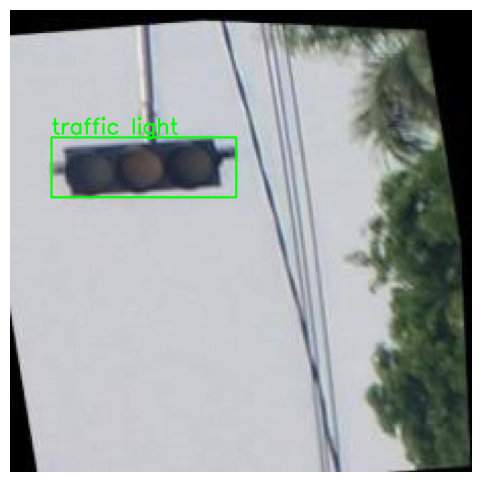

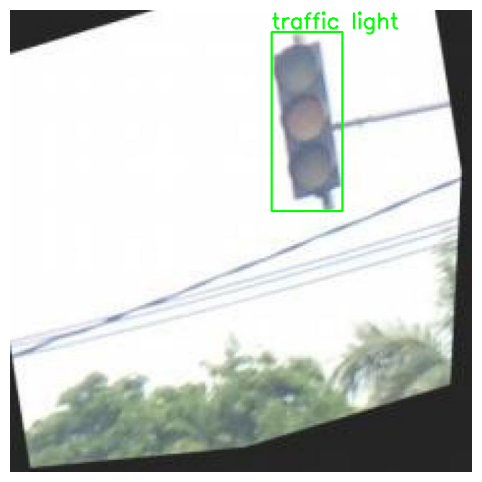

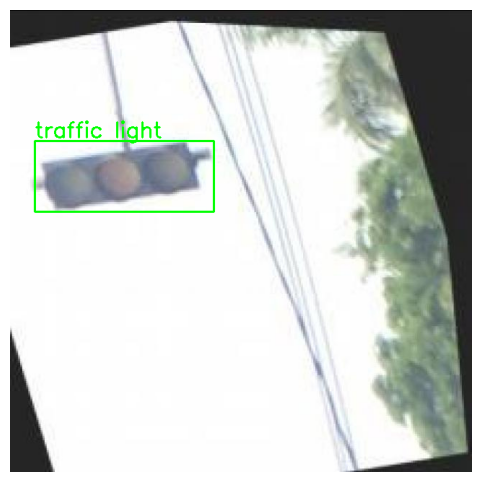

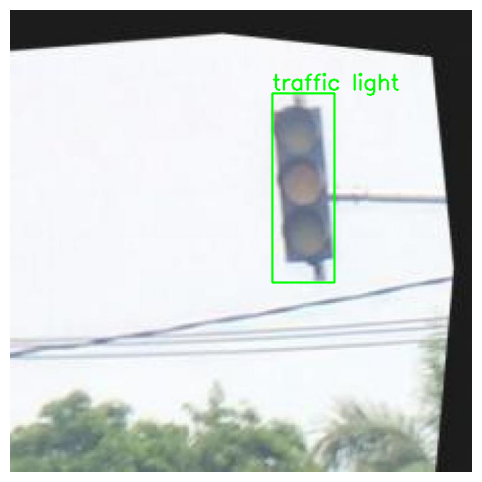

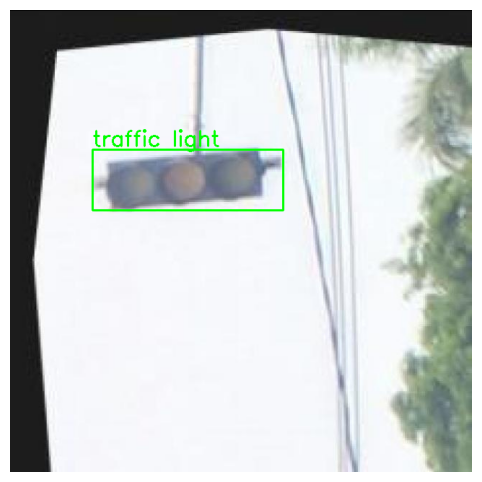

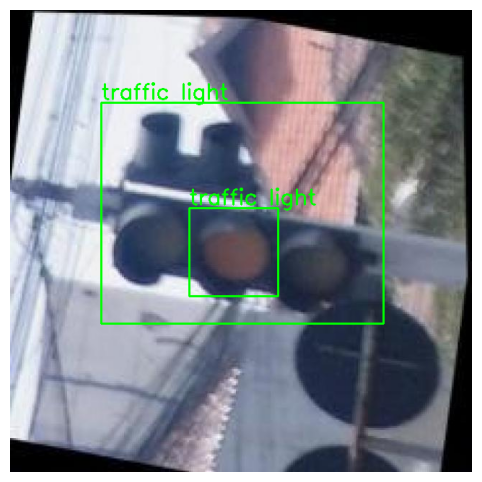

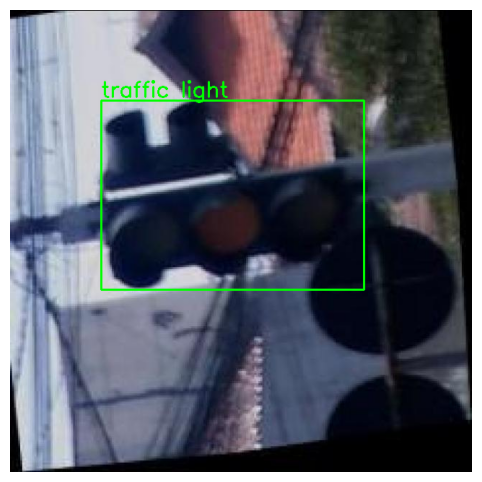

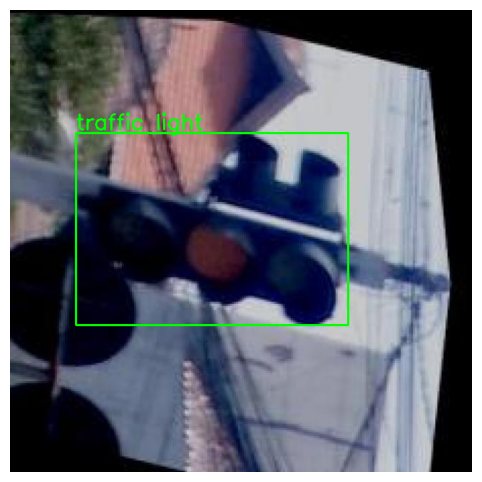

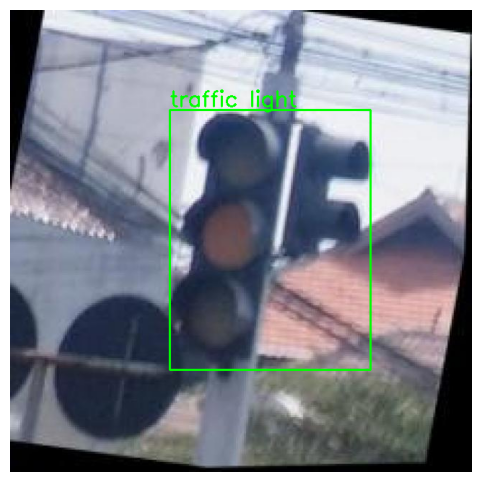

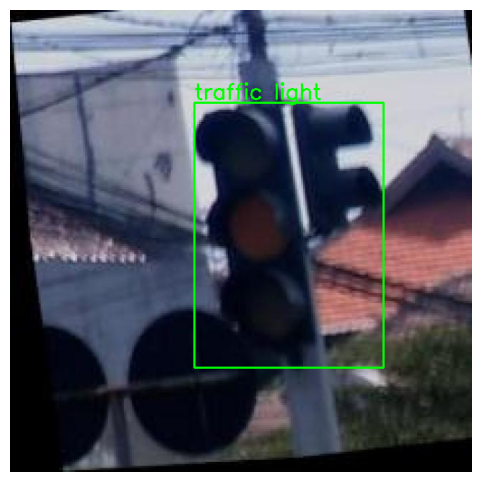

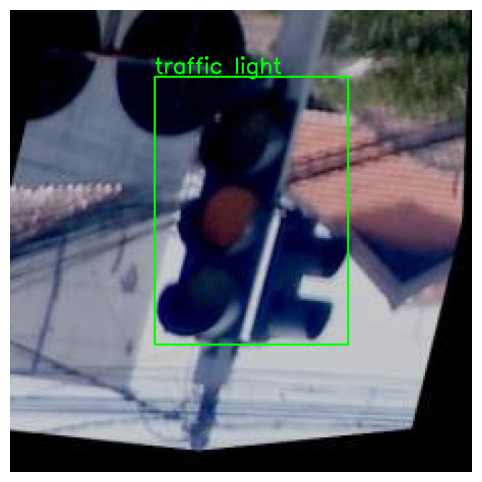

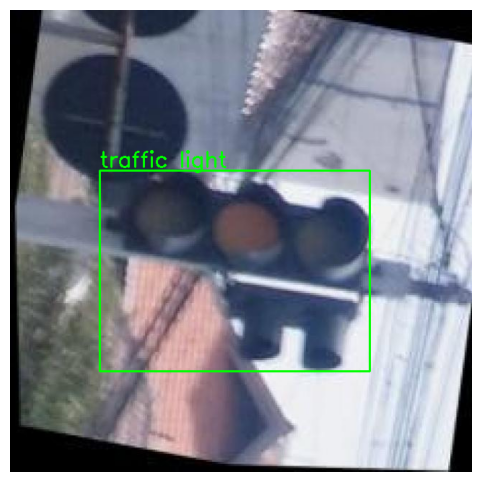

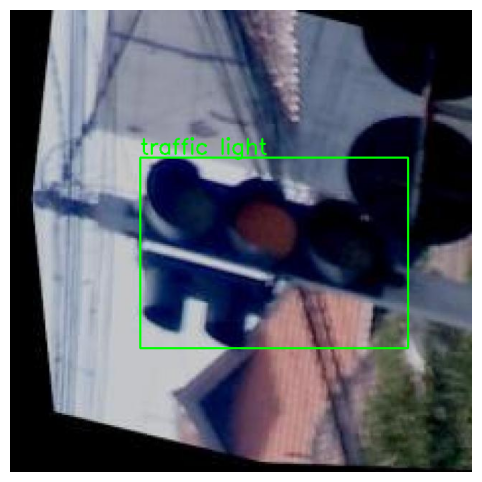

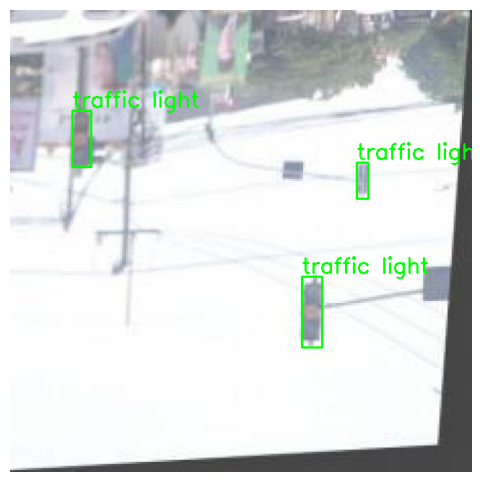

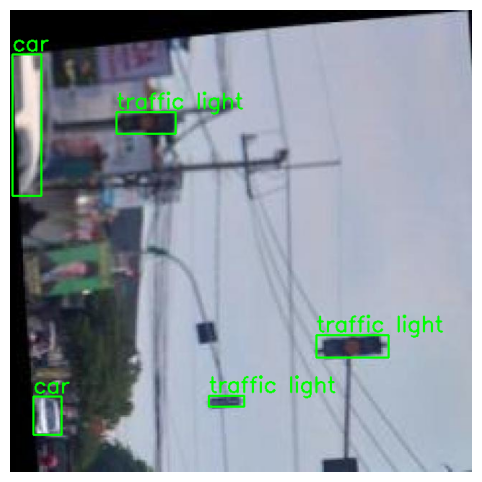

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml
%matplotlib inline

def load_image(image_path):
    """Load an image from the specified path."""
    return cv2.imread(image_path)

def load_labels(label_file):
    """Load bounding box labels from a text file."""
    try:
        with open(label_file, "r") as file:
            lines = file.readlines()
        bboxes = []
        for line in lines:
            values = line.strip().split()
            box = [float(i) for i in values]
            bboxes.append(box)
        return bboxes
    except FileNotFoundError:
        print('Label file not found:', label_file)
        return []

def draw_bounding_boxes(image, bboxes, class_names):
    """Draw bounding boxes with labels on the image."""
    for bbox in bboxes:
        class_id, x_center, y_center, width, height = bbox
        image_height, image_width, _ = image.shape
        x_min = int((x_center - width / 2) * image_width)
        y_min = int((y_center - height / 2) * image_height)
        box_width = int(width * image_width)
        box_height = int(height * image_height)
        color = (0, 255, 0)  # Green color for bounding boxes

        cv2.rectangle(image, (x_min, y_min), (x_min + box_width, y_min + box_height), color, 2)

        if class_id in class_names:
            class_name = class_names[class_id]
            label = f"{class_name}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            font_thickness = 2
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
            cv2.putText(image, label, (x_min, y_min - 5), font, font_scale, color, font_thickness)

def main():
    # class_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck',
    #             8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench',
    #             14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear',
    #             22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase',
    #             29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat',
    #             35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle',
    #             40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana',
    #             47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza',
    #             54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table',
    #             61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone',
    #             68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock',
    #             75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush', 80: 'cone'}
    
    # class_names ={0: 'airplane',
    #                 1: 'apple',
    #                 2: 'backpack',
    #                 3: 'banana',
    #                 4: 'baseball bat',
    #                 5: 'baseball glove',
    #                 6: 'bear',
    #                 7: 'bed',
    #                 8: 'bench',
    #                 9: 'bicycle',
    #                 10: 'bird',
    #                 11: 'boat',
    #                 12: 'book',
    #                 13: 'bottle',
    #                 14: 'bowl',
    #                 15: 'broccoli',
    #                 16: 'bus',
    #                 17: 'cake',
    #                 18: 'car',
    #                 19: 'carrot',
    #                 20: 'cat',
    #                 21: 'cell phone',
    #                 22: 'chair',
    #                 23: 'clock',
    #                 24: 'couch',
    #                 25: 'cow',
    #                 26: 'cup',
    #                 27: 'dining table',
    #                 28: 'dog',
    #                 29: 'donut',
    #                 30: 'elephant',
    #                 31: 'fire hydrant',
    #                 32: 'fork',
    #                 33: 'frisbee',
    #                 34: 'giraffe',
    #                 35: 'hair drier',
    #                 36: 'handbag',
    #                 37: 'horse',
    #                 38: 'hot dog',
    #                 39: 'keyboard',
    #                 40: 'kite',
    #                 41: 'knife',
    #                 42: 'laptop',
    #                 43: 'microwave',
    #                 44: 'motorcycle',
    #                 45: 'mouse',
    #                 46: 'orange',
    #                 47: 'oven',
    #                 48: 'parking meter',
    #                 49: 'person',
    #                 50: 'pizza',
    #                 51: 'potted plant',
    #                 52: 'refrigerator',
    #                 53: 'remote',
    #                 54: 'sandwich',
    #                 55: 'scissors',
    #                 56: 'sheep',
    #                 57: 'sink',
    #                 58: 'skateboard',
    #                 59: 'skis',
    #                 60: 'snowboard',
    #                 61: 'spoon',
    #                 62: 'sports ball',
    #                 63: 'stop sign',
    #                 64: 'suitcase',
    #                 65: 'surfboard',
    #                 66: 'teddy bear',
    #                 67: 'tennis racket',
    #                 68: 'tie',
    #                 69: 'toaster',
    #                 70: 'toilet',
    #                 71: 'toothbrush',
    #                 72: 'traffic light',
    #                 73: 'train',
    #                 74: 'truck',
    #                 75: 'tv',
    #                 76: 'umbrella',
    #                 77: 'vase',
    #                 78: 'wine glass',
    #                 79: 'zebra',
    #                 80: 'cone', 
    #                 81:'speed sign'}
    class_names = {
    0: 'person',
   1: 'bicycle',
   2: 'car',
   3: 'motorcycle',
   4: 'airplane',
   5: 'bus',
   6: 'train',
   7: 'truck',
   8: 'boat',
   9: 'traffic light',
   10: 'fire hydrant',
   11: 'stop sign',
   12: 'parking meter',
   13: 'bench',
   14: 'bird',
   15: 'cat',
   16: 'dog',
   17: 'horse',
   18: 'sheep',
   19: 'cow',
   20: 'elephant',
   21: 'bear',
   22: 'zebra',
   23: 'giraffe',
   24: 'backpack',
   25: 'umbrella',
   26: 'handbag',
   27: 'tie',
   28: 'suitcase',
   29: 'frisbee',
   30: 'skis',
   31: 'snowboard',
   32: 'sports ball',
   33: 'kite',
   34: 'baseball bat',
   35: 'baseball glove',
   36: 'skateboard',
   37: 'surfboard',
   38: 'tennis racket',
   39: 'bottle',
   40: 'wine glass',
   41: 'cup',
   42: 'fork',
   43: 'knife',
   44: 'spoon',
   45: 'bowl',
   46: 'banana',
   47: 'apple',
   48: 'sandwich',
   49: 'orange',
   50: 'broccoli',
   51: 'carrot',
   52: 'hot dog',
   53: 'pizza',
   54: 'donut',
   55: 'cake',
   56: 'chair',
   57: 'couch',
   58: 'potted plant',
   59: 'bed',
   60: 'dining table',
   61: 'toilet',
   62: 'tv',
   63: 'laptop',
   64: 'mouse',
   65: 'remote',
   66: 'keyboard',
   67: 'cell phone',
   68: 'microwave',
   69: 'oven',
   70: 'toaster',
   71: 'sink',
   72: 'refrigerator',
   73: 'book',
   74: 'clock',
   75: 'vase',
   76: 'scissors',
   77: 'teddy bear',
   78: 'hair drier',
   79: 'toothbrush',
   80: 'cone',
   81: 'speed sign'
    }
    # Directory paths
    image_dir = '/media/avalocal/T9/harsha/datasets/Labelbox_data_final/images'
    label_dir = '/media/avalocal/T9/harsha/datasets/Labelbox_data_final/labels'

    # Load class names
    # with open("/home/avalocal/Documents/Sign-and-Cone-Detection/class_names.yml", "r") as file:
    #     class_names = yaml.safe_load(file)

    # Load images and process
    for image_path in os.listdir(image_dir)[:15]:
        image = load_image(os.path.join(image_dir, image_path))
        if image is None:
            print('Failed to load image:', image_path)
            continue

        label_file = os.path.join(label_dir, f"{os.path.splitext(image_path)[0]}.txt")
        bboxes = load_labels(label_file)
        
        draw_bounding_boxes(image, bboxes, class_names)

        # Display the image with bounding boxes using matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    main()


In [12]:
# Build a YOLOv9c model from pretrained weight
model = YOLO('yolov9c.pt')
# Display model information (optional)
# model.info()

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(
    data="/home/avalocal/Documents/yolov9_ros/src/yolov9ros/src/yolov9/dataset.yaml", epochs=60, device=[0,1]
)  # train the model 

New https://pypi.org/project/ultralytics/8.2.28 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.8 🚀 Python-3.8.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24240MiB)
                                                          CUDA:1 (NVIDIA GeForce RTX 3090 Ti, 24248MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/home/avalocal/Documents/yolov9_ros/src/yolov9ros/src/yolov9/dataset.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=train16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


Ultralytics YOLOv8.2.8 🚀 Python-3.8.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24240MiB)
                                                          CUDA:1 (NVIDIA GeForce RTX 3090 Ti, 24248MiB)
WARNING ⚠️ Comet installed but not initialized correctly, not logging this run. Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 
TensorBoard: Start with 'tensorboard --logdir runs/detect/train16', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=82
Transferred 931/937 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /media/avalocal/T9/harsha/datasets/Labelbox_data_final/labels... 35066 images, 174 backgrounds, 0 corrupt: 100%|██████████| 35231/35231 [00:25<00:00, 1375.50it/s]


train: New cache created: /media/avalocal/T9/harsha/datasets/Labelbox_data_final/labels.cache


val: Scanning /media/avalocal/T9/harsha/datasets/coco_mini/labels/val.cache... 7076 images, 50 backgrounds, 0 corrupt: 100%|██████████| 7124/7124 [00:00<?, ?it/s]


Plotting labels to runs/detect/train16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 16 dataloader workers
Logging results to runs/detect/train16
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      6.25G     0.9777      1.542      1.182         66        640: 100%|██████████| 2202/2202 [06:37<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:42<00:00, 10.55it/s]


                   all       7124      38564      0.609      0.528      0.545      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      5.97G      1.095      1.406       1.26        110        640: 100%|██████████| 2202/2202 [06:04<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.04it/s]


                   all       7124      38564      0.527      0.409      0.409      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      6.08G      1.273      1.763      1.396         64        640: 100%|██████████| 2202/2202 [05:56<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 10.95it/s]


                   all       7124      38564      0.396      0.296      0.269      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      5.98G       1.36      1.969      1.468         75        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.02it/s]


                   all       7124      38564       0.45      0.323      0.313      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      5.98G      1.307      1.814      1.428         84        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.03it/s]


                   all       7124      38564      0.499      0.362      0.362      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      6.01G       1.26      1.692      1.397         81        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.08it/s]


                   all       7124      38564      0.522       0.39       0.39       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60         6G      1.229      1.602      1.373         81        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.11it/s]


                   all       7124      38564      0.548      0.408      0.427       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      5.98G      1.209      1.549      1.357        100        640: 100%|██████████| 2202/2202 [05:51<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.10it/s]


                   all       7124      38564      0.543      0.425      0.442      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      5.97G       1.19      1.494      1.347         58        640: 100%|██████████| 2202/2202 [05:51<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.10it/s]


                   all       7124      38564      0.568      0.446      0.467      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60         6G      1.167      1.454      1.336         31        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.13it/s]


                   all       7124      38564      0.586      0.465      0.487       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      5.97G      1.151      1.401      1.321         66        640: 100%|██████████| 2202/2202 [05:53<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.13it/s]


                   all       7124      38564      0.608      0.462      0.498      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60         6G      1.144      1.378      1.313        121        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.15it/s]


                   all       7124      38564      0.566      0.486      0.508      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      5.99G      1.128      1.351      1.302        117        640: 100%|██████████| 2202/2202 [05:53<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.11it/s]


                   all       7124      38564      0.584      0.502      0.519      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      5.97G      1.122      1.329      1.296         65        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.14it/s]


                   all       7124      38564      0.605      0.501      0.532       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      5.97G       1.11      1.301      1.287         73        640: 100%|██████████| 2202/2202 [05:53<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.11it/s]


                   all       7124      38564      0.627      0.501      0.538      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      5.99G      1.101      1.278      1.283         65        640: 100%|██████████| 2202/2202 [05:53<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.14it/s]


                   all       7124      38564      0.631      0.502      0.543       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      5.97G      1.091      1.257      1.278         57        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.12it/s]


                   all       7124      38564      0.625       0.52      0.552      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      5.97G      1.082       1.24      1.269         50        640: 100%|██████████| 2202/2202 [05:53<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.15it/s]


                   all       7124      38564      0.636      0.518      0.555      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      5.96G      1.078      1.224      1.264         80        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.18it/s]


                   all       7124      38564      0.636      0.525      0.561      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      5.99G      1.071      1.209      1.258         51        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.17it/s]


                   all       7124      38564      0.654      0.525      0.567       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      5.97G      1.069      1.193      1.256        130        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.13it/s]


                   all       7124      38564      0.655      0.528      0.569      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      5.97G      1.059      1.176      1.254         89        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.17it/s]


                   all       7124      38564      0.655      0.528      0.572      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      5.97G      1.052      1.152      1.244         69        640: 100%|██████████| 2202/2202 [05:53<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.15it/s]


                   all       7124      38564      0.654      0.533      0.573      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      5.99G      1.051      1.153      1.243         92        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.19it/s]


                   all       7124      38564      0.658      0.535      0.576       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      5.99G      1.048       1.14       1.24         65        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.13it/s]


                   all       7124      38564      0.658      0.538      0.579      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      5.97G      1.029      1.112      1.227         95        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.15it/s]


                   all       7124      38564      0.659      0.542       0.58      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      5.99G      1.035      1.099      1.228         50        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.19it/s]


                   all       7124      38564       0.66      0.542      0.582      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      5.96G      1.024      1.094      1.223         88        640: 100%|██████████| 2202/2202 [05:53<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.21it/s]


                   all       7124      38564      0.668      0.538      0.583      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      5.97G      1.017      1.083       1.22         66        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.13it/s]


                   all       7124      38564      0.672      0.538      0.585      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      5.97G      1.013      1.072      1.218         39        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.18it/s]


                   all       7124      38564      0.673      0.538      0.586      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      5.97G      1.007      1.059      1.213         84        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.16it/s]


                   all       7124      38564      0.679      0.535      0.588       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      5.96G      1.007      1.046      1.214         53        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.20it/s]


                   all       7124      38564      0.682      0.535      0.589      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      5.97G      1.001      1.039      1.208         56        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.14it/s]


                   all       7124      38564       0.67      0.542       0.59      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      5.97G     0.9959      1.022      1.207         64        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.20it/s]


                   all       7124      38564      0.668      0.546      0.591      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      5.96G     0.9893      1.011      1.197         47        640: 100%|██████████| 2202/2202 [05:53<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.22it/s]


                   all       7124      38564      0.678       0.54      0.592      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      5.99G     0.9864      1.002      1.194         79        640: 100%|██████████| 2202/2202 [05:51<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.22it/s]


                   all       7124      38564      0.669      0.547      0.592      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      5.96G     0.9745      0.984      1.186        119        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.18it/s]


                   all       7124      38564      0.674      0.545      0.593      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      5.98G     0.9707     0.9704      1.185         56        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.19it/s]


                   all       7124      38564      0.677      0.545      0.594      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      5.98G      0.966       0.96      1.183         74        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.22it/s]


                   all       7124      38564      0.677      0.546      0.595      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      5.96G     0.9582     0.9476      1.177         48        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.21it/s]


                   all       7124      38564      0.675      0.548      0.595      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      5.96G     0.9534     0.9384      1.173         71        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.17it/s]


                   all       7124      38564      0.677      0.548      0.596      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      5.99G     0.9524     0.9221      1.171         49        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.21it/s]


                   all       7124      38564      0.675      0.549      0.597      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      5.96G     0.9444     0.9213       1.17         45        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.20it/s]


                   all       7124      38564      0.683      0.548      0.598      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      5.97G     0.9403     0.9064      1.159         52        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.21it/s]


                   all       7124      38564      0.682       0.55      0.598      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      5.96G      0.935     0.8836      1.157         57        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.16it/s]


                   all       7124      38564      0.683       0.55      0.598      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      5.96G     0.9273     0.8779       1.15         89        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.17it/s]


                   all       7124      38564      0.684      0.551      0.599       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      5.96G     0.9254     0.8666      1.152         76        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.19it/s]


                   all       7124      38564      0.682      0.552      0.599      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      5.97G     0.9177     0.8592      1.151         66        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.21it/s]


                   all       7124      38564      0.679      0.555        0.6      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      5.96G     0.9105     0.8443      1.143         91        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.16it/s]


                   all       7124      38564       0.68      0.557      0.601      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      5.96G     0.9019     0.8283      1.139         66        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.23it/s]


                   all       7124      38564      0.678      0.557      0.601      0.442
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      5.96G     0.8707     0.7222      1.108         67        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.21it/s]


                   all       7124      38564      0.674       0.56      0.601      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      5.96G     0.8586        0.7      1.101         62        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.24it/s]


                   all       7124      38564      0.674      0.561      0.602      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      5.96G     0.8549     0.6867      1.093         19        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.19it/s]


                   all       7124      38564      0.674      0.561      0.602      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      5.96G     0.8461     0.6684      1.093         27        640: 100%|██████████| 2202/2202 [05:51<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.24it/s]


                   all       7124      38564      0.676       0.56      0.602      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      5.96G     0.8374     0.6542      1.087         28        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:40<00:00, 11.15it/s]


                   all       7124      38564      0.679      0.556      0.602      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      5.96G     0.8257     0.6376      1.076         67        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.19it/s]


                   all       7124      38564      0.681      0.556      0.602      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      5.96G     0.8176     0.6227      1.068         39        640: 100%|██████████| 2202/2202 [05:51<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.25it/s]


                   all       7124      38564      0.683      0.555      0.602      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      5.98G     0.8135     0.6076      1.067         35        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.24it/s]


                   all       7124      38564      0.683      0.555      0.602      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      5.95G     0.8044     0.5944      1.058         35        640: 100%|██████████| 2202/2202 [05:52<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.20it/s]


                   all       7124      38564      0.679      0.558      0.602      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      5.97G     0.8044     0.5884      1.061         61        640: 100%|██████████| 2202/2202 [05:51<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.27it/s]


                   all       7124      38564      0.676      0.559      0.602      0.442

60 epochs completed in 6.589 hours.
Optimizer stripped from runs/detect/train16/weights/last.pt, 51.7MB
Optimizer stripped from runs/detect/train16/weights/best.pt, 51.7MB

Validating runs/detect/train16/weights/best.pt...
Ultralytics YOLOv8.2.8 🚀 Python-3.8.19 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24240MiB)
                                                          CUDA:1 (NVIDIA GeForce RTX 3090 Ti, 24248MiB)
YOLOv9c summary (fused): 384 layers, 25382470 parameters, 0 gradients, 102.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:39<00:00, 11.42it/s]


                   all       7124      38564      0.677      0.559      0.602      0.443
                person       7124      10777      0.821      0.709      0.804      0.585
               bicycle       7124        314      0.689      0.452      0.529       0.33
                   car       7124       1918      0.681      0.605      0.644      0.439
            motorcycle       7124        367      0.765       0.64      0.731      0.476
              airplane       7124        143      0.804      0.776      0.852      0.693
                   bus       7124        283      0.777      0.753      0.813      0.697
                 train       7124        190      0.807      0.826      0.872      0.718
                 truck       7124        414       0.59      0.471      0.528      0.372
                  boat       7124        424       0.68      0.387      0.485      0.276
         traffic light       7124        634      0.692      0.465      0.509      0.271
          fire hydran

In [13]:
# Testing on test image
# test_dataset_dir = (
#     "/home/avalocal/Documents/yolov9_ros/src/yolov9ros/src/yolov9/cone_images"
# )
test_dataset_dir = '/media/avalocal/T9/harsha/datasets/cones_data/test/images'
# Get the list of images in the test dataset directory
test_images = os.listdir(test_dataset_dir)

# model = YOLO(
#     '/home/avalocal/Documents/yolov9_ros/src/yolov9ros/src/yolov9/runs/detect/train6/weights/best.pt'
# )
model = YOLO(
    "/home/avalocal/Documents/Sign-and-Cone-Detection/runs/detect/train14/weights/best.pt"
)

# for image_name in test_images[0, len(test_images), 100]:
print(model.names)
for img_id in range(0, len(test_images), 25):
    # Load the image
    image_path = os.path.join(test_dataset_dir, test_images[img_id])
    image = cv2.imread(image_path)
    image.shape
    detections = model(image)
    result = detections[0]
    class_id = result.boxes.cls.cpu().numpy()  # Class IDs
    confidence = result.boxes.conf.cpu().numpy()  # Confidence scores

    bboxes = np.array(result.boxes.xyxy.cpu(), dtype="int")  # Bounding boxes
    for i, bbox in enumerate(bboxes):
        (x, y, x2, y2) = bbox
        cv2.rectangle(image, (x, y), (x2, y2), (0, 0, 225), 2)
        # label = f"car: {float('{:.2f}'.format(confidence[i]))}"
        label = f"{model.names[int(class_id[i])]}: {float('{:.2f}'.format(confidence[i]))}"
        cv2.putText(
            image,
            label,
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 225),
            2,
        )

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/avalocal/Documents/Sign-and-Cone-Detection/runs/detect/train16/weights/best.pt'